# Assignment 3.1

Working on tree visualization using regraded dataset that only includes most important features according to the feature selection previous pipeline **and also using upsampling of the minority class to try to solve the heavy imbalanced class problem**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set()

In [3]:
sample_df = pd.read_csv('data/regraded_sample_df.csv')
sample_df.status_binary.value_counts()

1    255202
0     32313
Name: status_binary, dtype: int64

In [6]:
#Template code from https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = sample_df[sample_df.status_binary==1]
df_minority = sample_df[sample_df.status_binary==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
upsampled_df = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
upsampled_df.status_binary.value_counts()

1    255202
0    255202
Name: status_binary, dtype: int64

In [7]:
X = upsampled_df.iloc[:,:-1]
y = upsampled_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
model = RandomForestClassifier(max_depth=3)
model.fit(X_train,y_train)

# What about AUROC? (test set)
prob_y = model.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_test, prob_y))

0.6746231776114078


In [26]:
# Feature names
features = X_train.columns

# Ranking calification of Decistion Tree model
ranking = model.feature_importances_

zipped = list(zip(features, ranking))

df = pd.DataFrame(zipped, columns = ['Features', 'Ranking']) 
   
# Order data according to ranking
df = df.sort_values(by='Ranking', ascending=False)

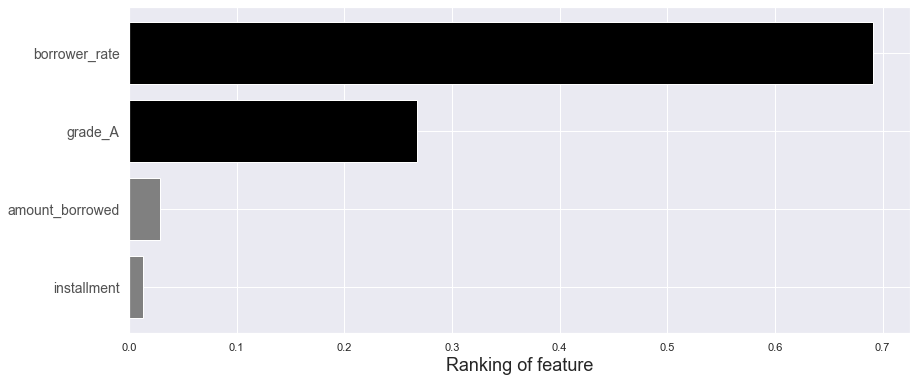

In [28]:
fig, ax = plt.subplots(figsize=(14,6))
labels = df['Features']
pos = np.arange(len(labels))
values=df['Ranking']
colors = ['black','black']
colors.extend(['grey']*(len(labels)-2))
ax.barh(labels, values, color=colors)
plt.xlabel('Ranking of feature', fontsize=18)
plt.yticks(pos, labels, alpha = 0.8, fontsize=14)
ax.invert_yaxis()
plt.savefig('graphics/FeatureRanking_Reduced.png')

In [12]:
# fit a logistic model, to see if there is any difference with the random forest one
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.675
Logistic: ROC AUC=0.511


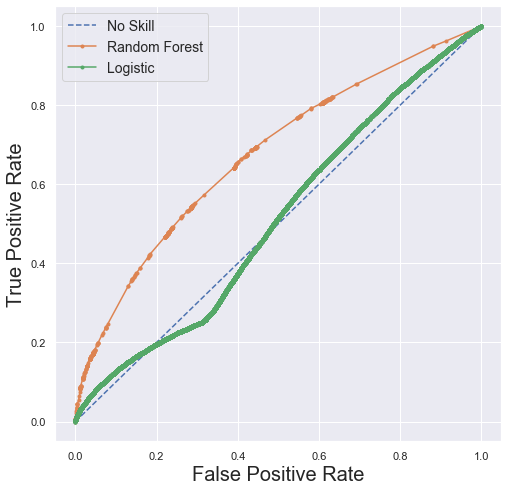

In [21]:
#Template Code from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
rf_probs = model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
# show the legend
plt.legend(fontsize=14)
# show the plot
plt.savefig('graphics/ROC_selection.png')

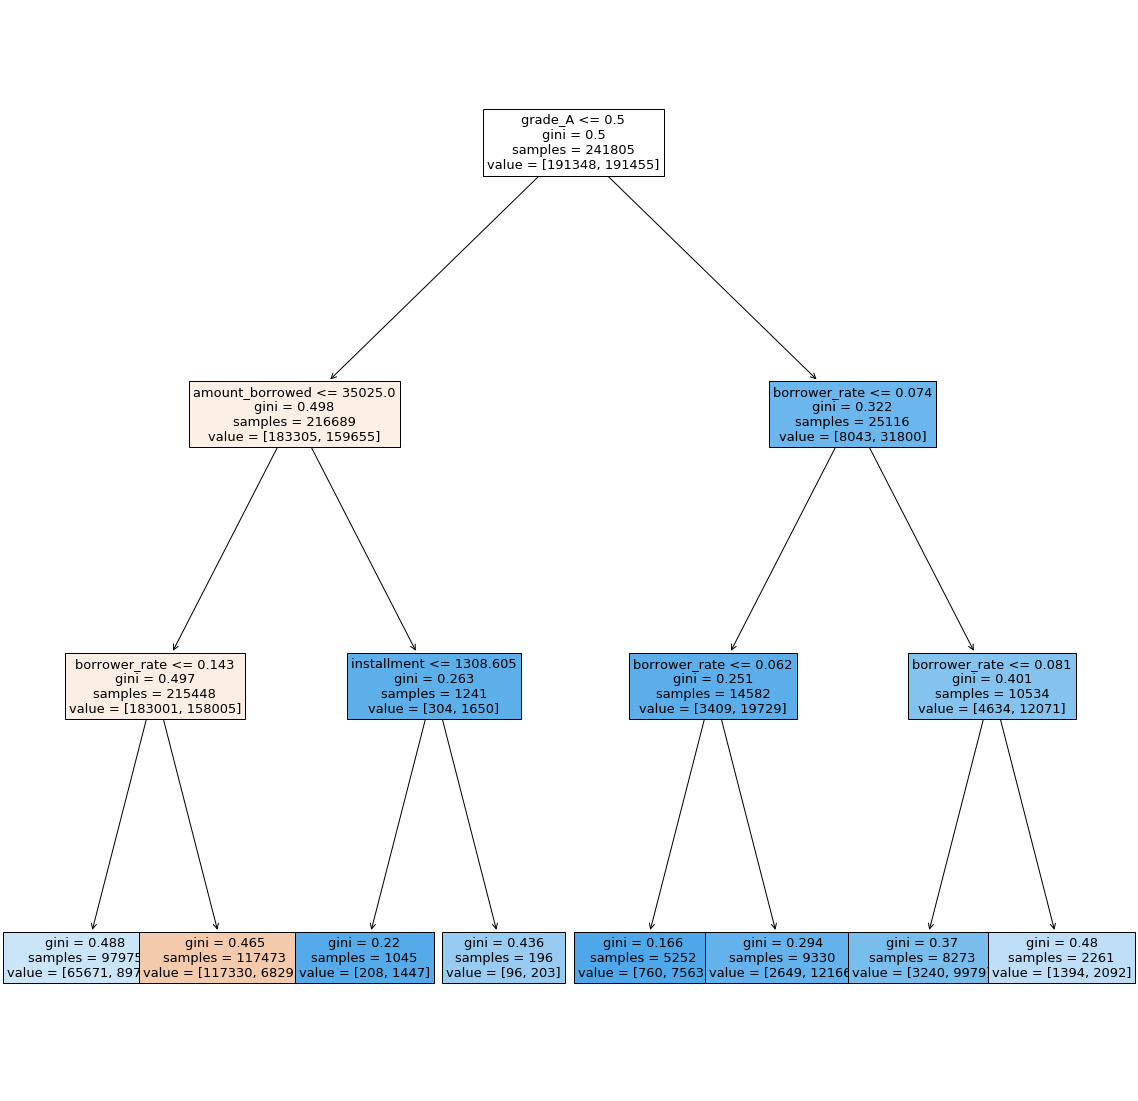

In [14]:
from sklearn import tree
from dtreeviz.trees import dtreeviz

plt.figure(figsize=(20,20))
_ = tree.plot_tree(model.estimators_[3], feature_names=X.columns, fontsize=13, filled=True)
plt.savefig('tree.png')

/home/khaerus/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


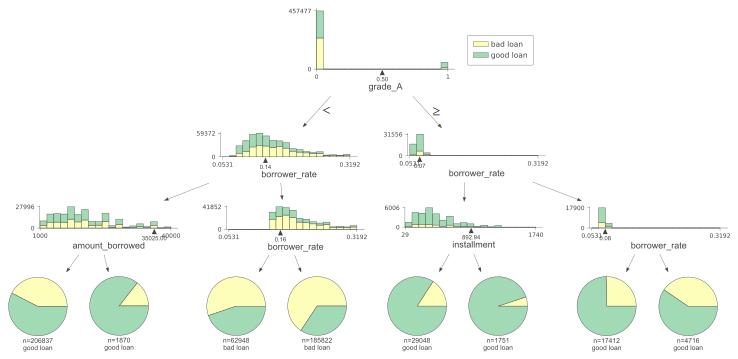

In [15]:
viz = dtreeviz(model.estimators_[5], X, y, feature_names=X.columns, class_names={0:'bad loan', 1:'good loan'})
viz

In [30]:
viz.save('graphics/DecisionTree.svg')

In [17]:
from sklearn.tree import export_graphviz

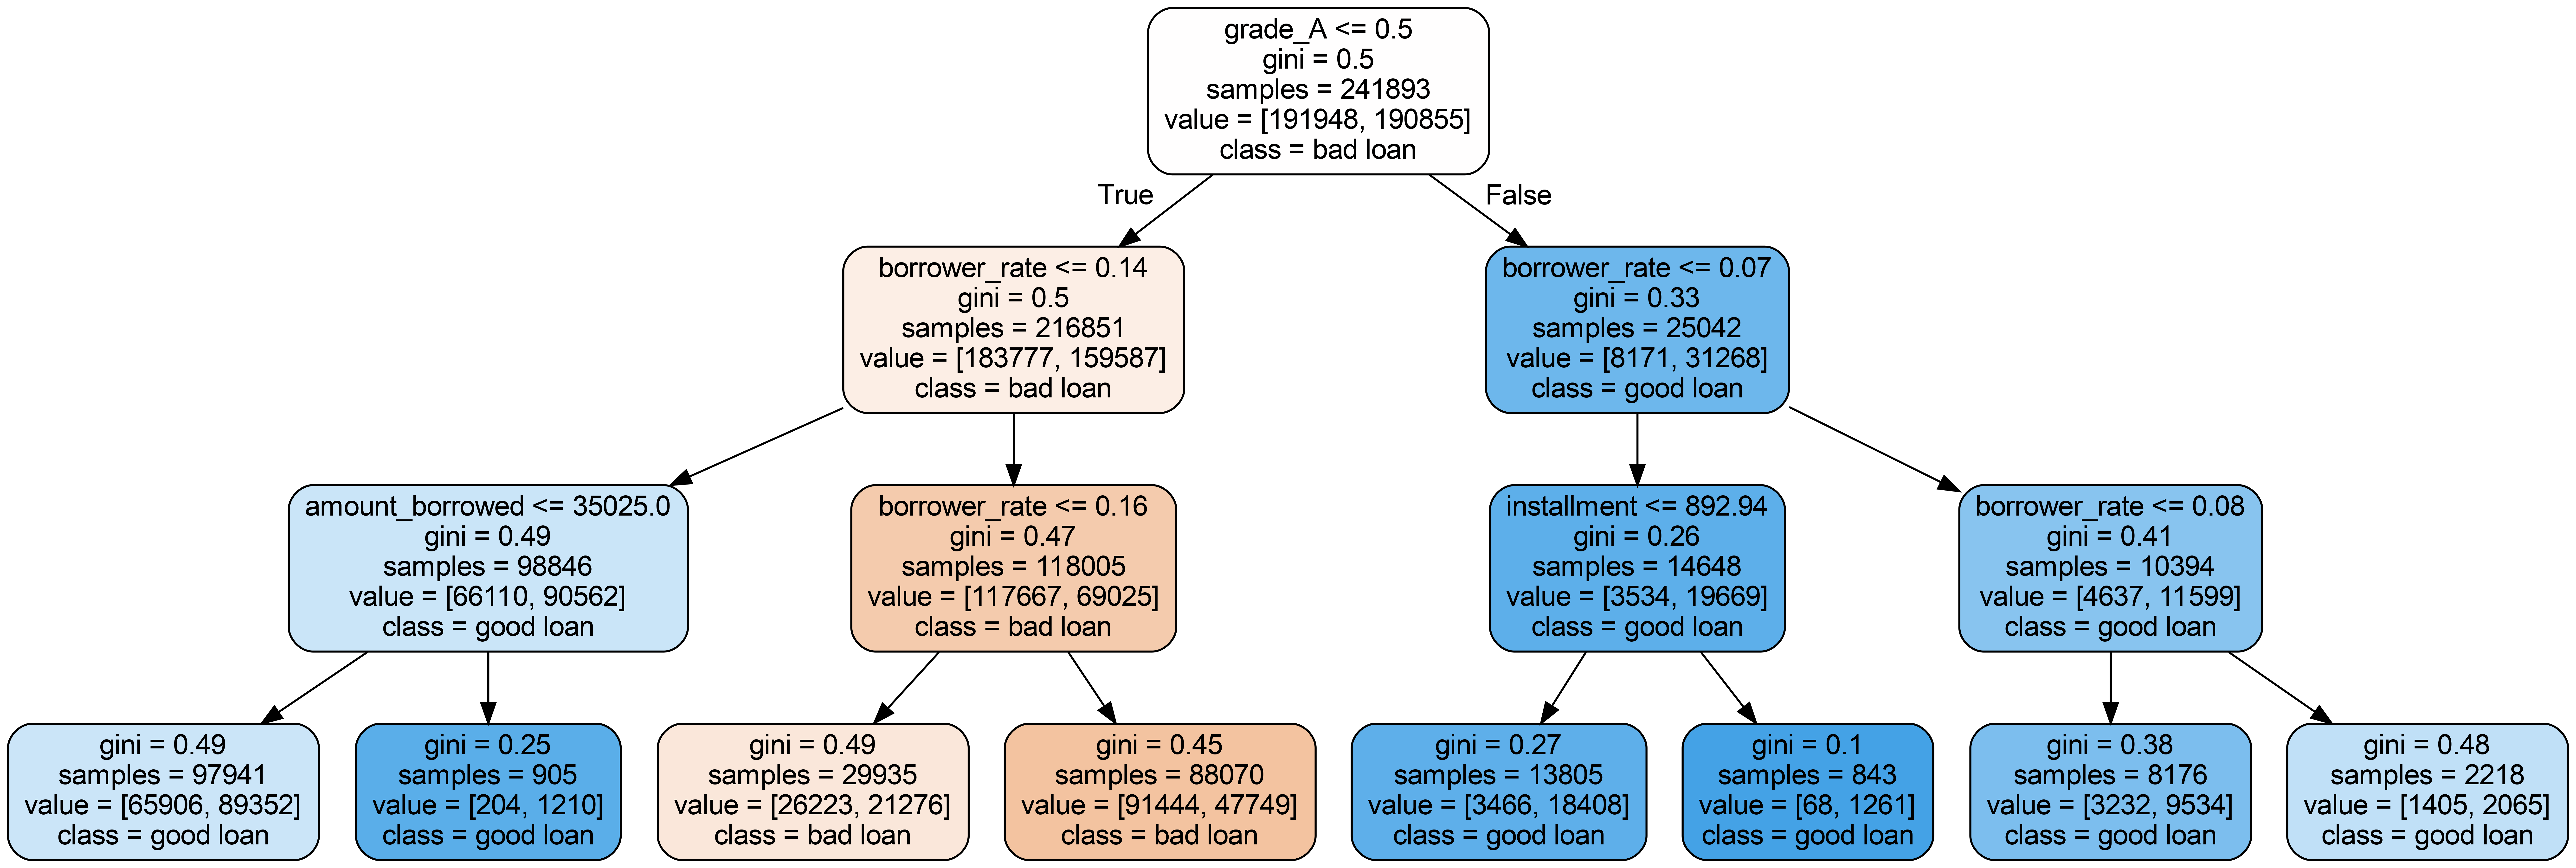

In [18]:
# Extract single tree
estimator = model.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['bad loan', 'good loan'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')